In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


In [106]:
df_train = pd.read_csv('training_set_features.csv')
df_labels = pd.read_csv('training_set_labels.csv')

In [107]:
df_train.shape

(26707, 36)

In [108]:
# Merge datasets on respondent_id
df = df_train.merge(df_labels,how = 'inner' ,on ='respondent_id')


In [109]:
df.shape

(26707, 38)

In [110]:
both_vac_ratio = df[(df['xyz_vaccine']==1) & (df['seasonal_vaccine']==1)].shape[0] / df.shape[0]
either_vac_ratio = df[(df['xyz_vaccine']==1) | (df['seasonal_vaccine']==1)].shape[0] / df.shape[0]
print("Percentage of respondents who received both vaccines: ", "{:.2%}".format(both_vac_ratio))
print("Percentage of respondents who received one of the vaccines: ", "{:.2%}".format(either_vac_ratio))

Percentage of respondents who received both vaccines:  17.59%
Percentage of respondents who received one of the vaccines:  50.22%


In [111]:
print(df['xyz_vaccine'].value_counts())
print(df['seasonal_vaccine'].value_counts())

0    21033
1     5674
Name: xyz_vaccine, dtype: int64
0    14272
1    12435
Name: seasonal_vaccine, dtype: int64


In [26]:
all_cols = df.columns.tolist()

opinion_cols = []
for col in df.columns.tolist():
    if col.startswith("opinion"):
        opinion_cols.append(col)

In [27]:
binary_cols = []
for col in df.columns.tolist():
    if df[col].nunique() <= 2:
        binary_cols.append(col)

In [28]:
household_cols = []
for col in df.columns.tolist():
    if col.startswith("household"):
        household_cols.append(col)

In [29]:
def make_stacked_chart(df, col, vaccine):
    df_grouped = pd.DataFrame(df.groupby(col)[vaccine].value_counts())
    df_grouped.columns = ['count']
    df_grouped = df_grouped.reset_index()
    
    pivot_df = df_grouped.pivot(index=[col], columns=vaccine, values=['count']).reset_index()
    
    pivot_df.set_index(col).plot(kind='bar', stacked=True, color=['steelblue', 'darkorange'])
    plt.title(f'Stacked Bar Chart {col}')
    plt.legend(['Non-vaccinated', 'Vaccinated'])
    plt.ylabel('Count')
    plt.show()
    

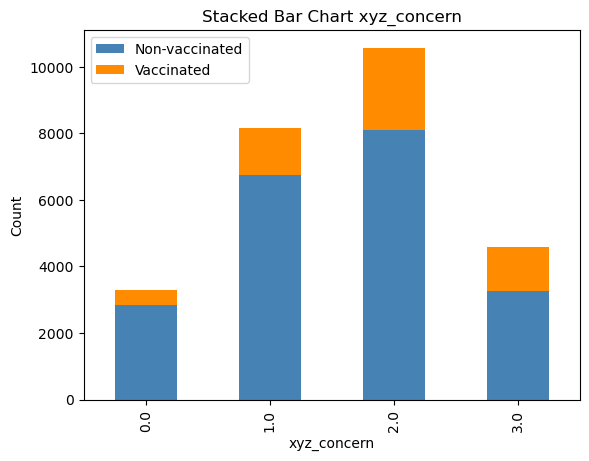

In [35]:
make_stacked_chart(df, 'xyz_concern', vaccine='xyz_vaccine')

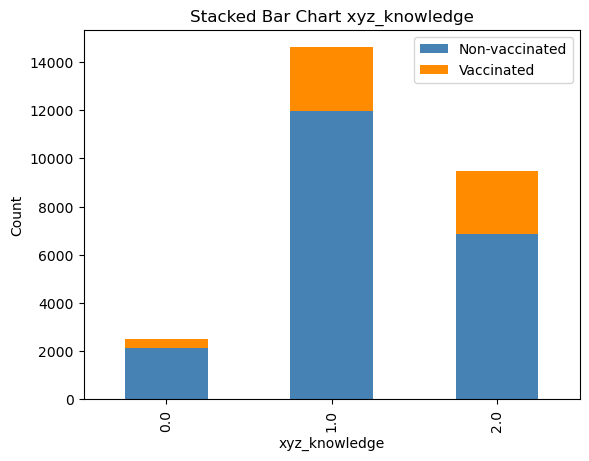

In [36]:
make_stacked_chart(df, 'xyz_knowledge', vaccine='xyz_vaccine') 

In [37]:
df.age_group.value_counts().index

Index(['65+ Years', '55 - 64 Years', '45 - 54 Years', '18 - 34 Years',
       '35 - 44 Years'],
      dtype='object')

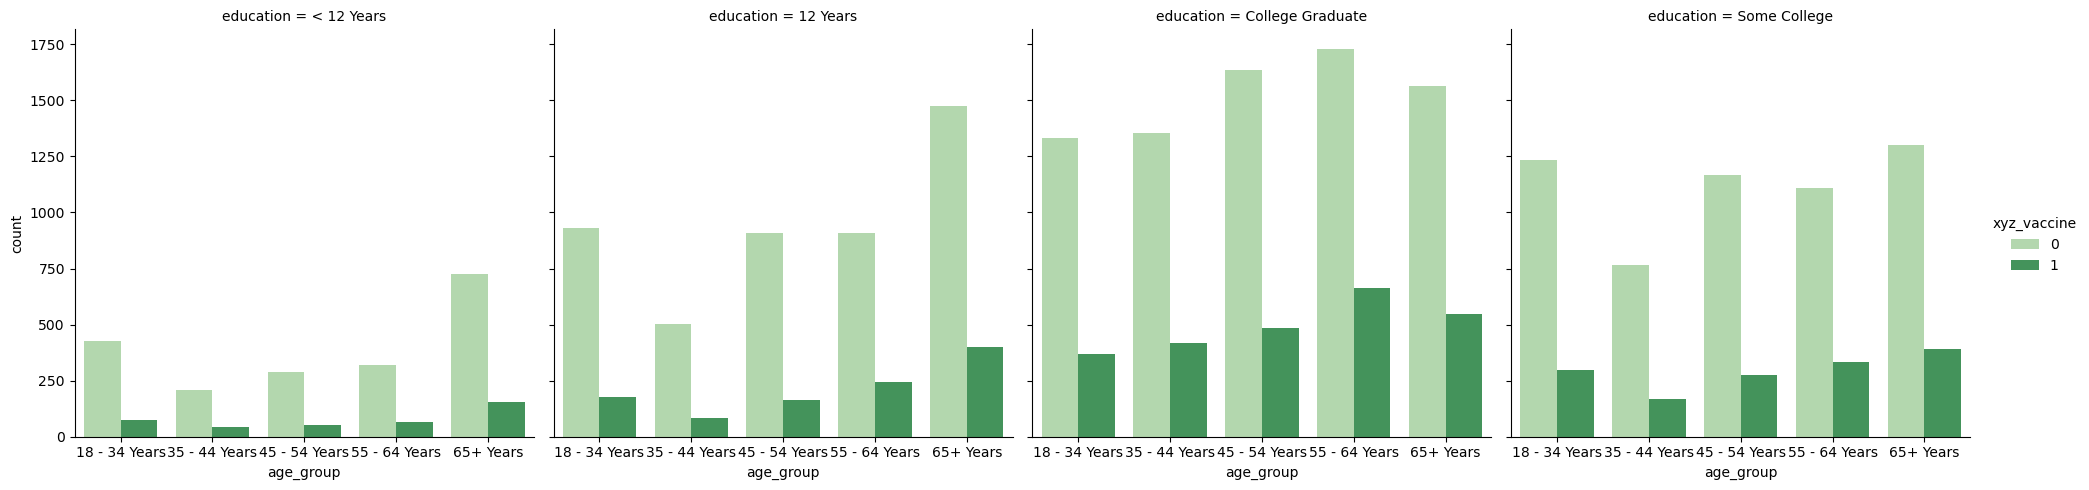

In [38]:
import seaborn as sns
g = sns.catplot(x="age_group", col="education",hue='xyz_vaccine',
                data= df, #maybe try re-ordering columns another time.
                kind="count", palette='Greens', order=['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
                )

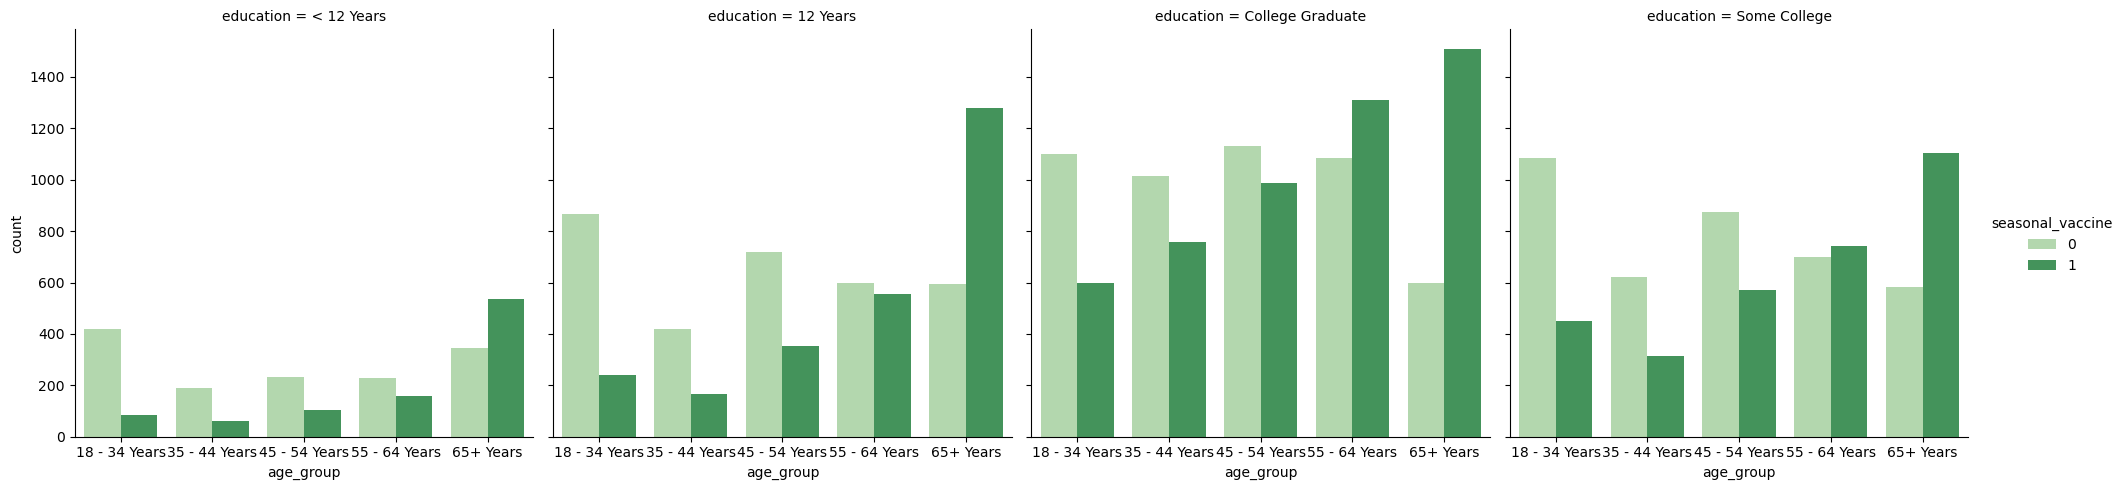

In [40]:
g = sns.catplot(x="age_group", col="education",hue='seasonal_vaccine',
                data=df, #maybe try re-ordering columns another time.
                kind="count", palette='Greens', order=['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']
                )

In [42]:
df['income_poverty'] = df['income_poverty'].map({'<= $75,000, Above Poverty':'<=75000 Above Poverty', '> $75,000':'>75000', 'Below Poverty':'Below Poverty'})

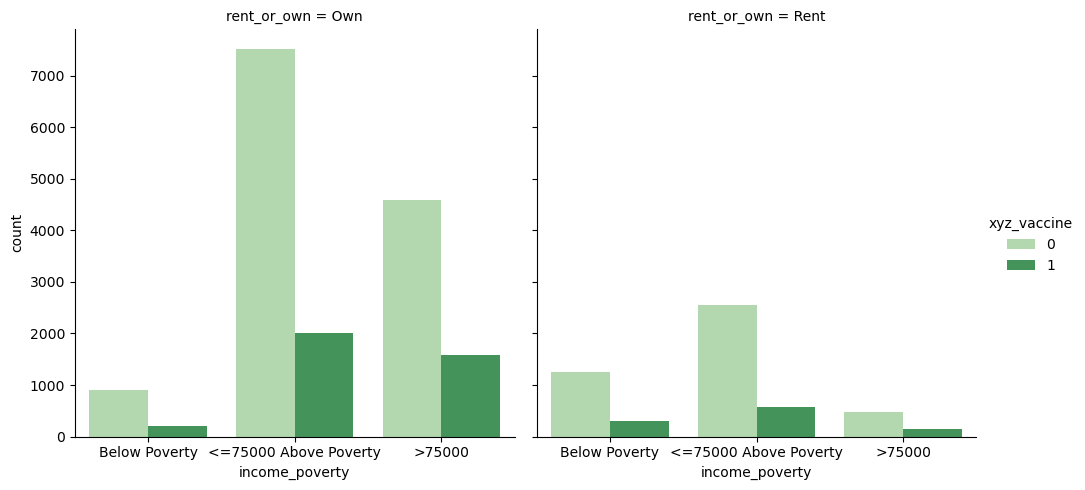

In [44]:
g = sns.catplot(x="income_poverty", col="rent_or_own",hue='xyz_vaccine',
                data=df, #maybe try re-ordering columns another time.
                kind="count", palette='Greens'
                )
g.figure.subplots_adjust(wspace=.05, hspace=.02)

In [45]:
df.isnull().sum().sort_values(ascending=False)

employment_occupation          13470
employment_industry            13330
health_insurance               12274
income_poverty                  4423
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
rent_or_own                     2042
employment_status               1463
marital_status                  1408
education                       1407
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
opinion_seas_sick_from_vacc      537
opinion_seas_risk                514
opinion_seas_vacc_effective      462
opinion_xyz_sick_from_vacc       395
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
household_adults                 249
household_children               249
behavioral_avoidance             208
behavioral_touch_face            128
xyz_knowledge                    116
xyz_concern                       92
behavioral_large_gatherings       87
behavioral_outside_home           82
b

In [112]:
# close to half the values of these columns are NULL so discarding
df.drop(['health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)

In [113]:
df['marital_status'].value_counts()

Married        13555
Not Married    11744
Name: marital_status, dtype: int64

In [114]:
df.isnull().sum()

respondent_id                     0
xyz_concern                      92
xyz_knowledge                   116
behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_xyz                2160
doctor_recc_seasonal           2160
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_xyz_vacc_effective      391
opinion_xyz_risk                388
opinion_xyz_sick_from_vacc      395
opinion_seas_vacc_effective     462
opinion_seas_risk               514
opinion_seas_sick_from_vacc     537
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                 

In [115]:
str_cols = df.select_dtypes(include = 'object').columns
df[str_cols].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City"
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


In [116]:
for col in df.columns:
    if df[col].isnull().sum() and df[col].dtypes != 'object':
        df[col].loc[(X[col].isnull())] = df[col].median()
for col in df.columns:
    if df[col].isnull().sum() and df[col].dtypes == 'object':
        df[col].loc[(df[col].isnull())] = df[col].mode().max()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29380\1508188429.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[(X[col].isnull())] = df[col].median()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29380\1508188429.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[(df[col].isnull())] = df[col].mode().max()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29380\1508188429.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [121]:
LE = LabelEncoder()
for col in str_cols:
    df[col] = LE.fit_transform(df[col])

In [122]:
df['cleanliness'] =  df['behavioral_antiviral_meds']+ df['behavioral_avoidance']+\
                        df['behavioral_face_mask']+df['behavioral_wash_hands']+\
                       df['behavioral_large_gatherings'] + df['behavioral_outside_home']+\
                       df['behavioral_touch_face']

In [123]:
df['cleanliness']

0        2.0
1        4.0
2        1.0
3        3.0
4        4.0
        ... 
26702    2.0
26703    2.0
26704    5.0
26705    1.0
26706    1.0
Name: cleanliness, Length: 26707, dtype: float64

In [124]:
df['opinion'] = df['opinion_xyz_vacc_effective'] + df['opinion_xyz_risk']+\
                  df['opinion_xyz_sick_from_vacc'] + df['opinion_seas_vacc_effective']+\
                  df['opinion_seas_risk'] + df['opinion_seas_sick_from_vacc']

In [125]:
df['opinion_xyz'] = df['opinion_xyz_vacc_effective'] + df['opinion_xyz_risk']-\
                  df['opinion_xyz_sick_from_vacc'] 
df['opinion_seasonal'] = df['opinion_seas_vacc_effective']+\
                  df['opinion_seas_risk'] - df['opinion_seas_sick_from_vacc']

In [126]:
df['concern>=2'] = np.where(df['xyz_concern']>=2,1,0) 
# Since those who have concern>=2 have a pronounced effect on vaccination

df['good_opinion_vacc'] = np.where(df['opinion_seas_vacc_effective'] == 3,1,0)
#If the opinion is 3 it means he/she has a good opinion and is more likely to take the vaccine

df['good_knowledge'] = np.where(df['xyz_knowledge'] == 2,1,0)
#Same kind of logic as mentioned previouf

In [127]:
df['risk'] = np.where(df['opinion_xyz_risk']>=4,1,0)

### Generating a column combining concern and knowledge, since they have seemingly good correlations

df['concern_knowledge'] = df['xyz_concern']+df['xyz_knowledge']

## square of age group to subtely improve the correlation of that feature with the vaccine probabilty
df['a^2'] = df['age_group']*df['age_group']

In [128]:
df.columns

Index(['respondent_id', 'xyz_concern', 'xyz_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_xyz', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
       'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'xyz_vaccine',
       'seasonal_vaccine', 'cleanliness', 'opinion', 'opinion_xyz',
       'opinion_seasonal', 'concern>=2', 'good_opinion_vacc', 'good_knowledge',
       'risk', 'concern_knowledge', 'a^2'],
      dtype='obj

In [129]:
df.drop(['race','child_under_6_months','opinion_xyz_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)

Y_label = df[['xyz_vaccine','seasonal_vaccine']]

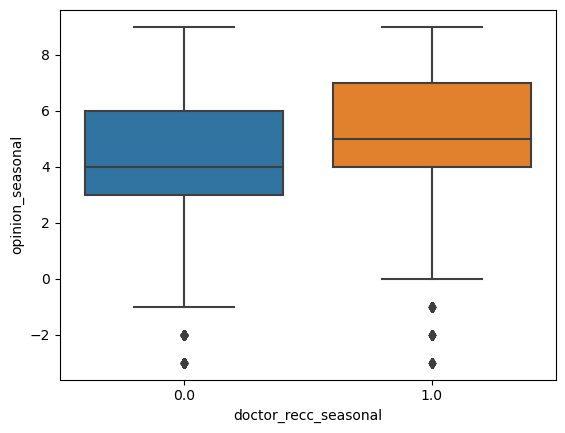

In [130]:
ax = sns.boxplot(x="doctor_recc_seasonal", y="opinion_seasonal", data=df)

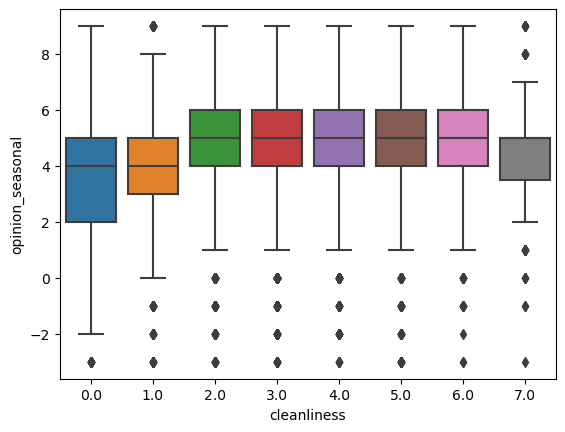

In [131]:
ax = sns.boxplot(x="cleanliness", y="opinion_seasonal", data=df)

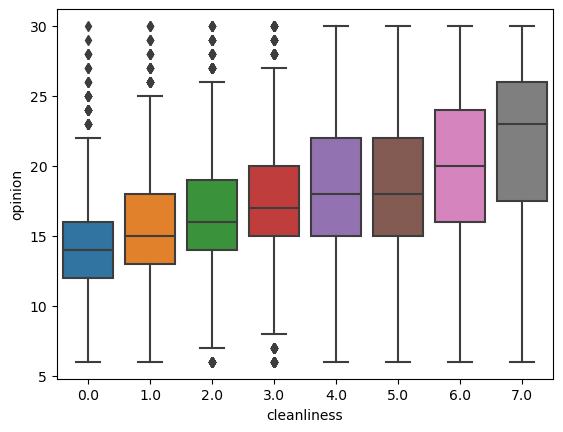

In [132]:
ax = sns.boxplot(x="cleanliness", y="opinion", data=df)

In [133]:
df.drop(['xyz_vaccine','seasonal_vaccine'],axis=1,inplace = True)
frames =[df,Y_label]
df = pd.concat(frames,axis=1)

In [134]:
df.head()

,respondent_id,xyz_concern,xyz_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,health_worker,opinion_xyz_vacc_effective,...,opinion_xyz,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2,xyz_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,...,2.0,1.0,0,0,0,0,1.0,9,0,0
1,1,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,...,5.0,2.0,1,0,1,1,5.0,1,0,1
2,2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,...,3.0,3.0,0,0,0,0,2.0,0,0,0
3,3,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,1.0,8.0,0,0,0,0,2.0,16,0,1
4,4,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,1,1,0,0,3.0,4,0,0


In [135]:
features = df.columns[:-2]
print(features)
labels = ['xyz_vaccine', 'seasonal_vaccine']

Index(['respondent_id', 'xyz_concern', 'xyz_knowledge',
       'behavioral_wash_hands', 'behavioral_touch_face', 'doctor_recc_xyz',
       'doctor_recc_seasonal', 'chronic_med_condition', 'health_worker',
       'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
       'opinion_seas_vacc_effective', 'opinion_seas_risk', 'age_group', 'sex',
       'rent_or_own', 'household_children', 'cleanliness', 'opinion',
       'opinion_xyz', 'opinion_seasonal', 'concern>=2', 'good_opinion_vacc',
       'good_knowledge', 'risk', 'concern_knowledge', 'a^2'],
      dtype='object')


In [136]:
train,test = train_test_split(df,test_size = 0.2,shuffle = True)
train_x,train_y = train[features],train[labels]
test_x,test_y = test[features],test[labels]

In [137]:
train_x.head()

,respondent_id,xyz_concern,xyz_knowledge,behavioral_wash_hands,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,health_worker,opinion_xyz_vacc_effective,...,cleanliness,opinion,opinion_xyz,opinion_seasonal,concern>=2,good_opinion_vacc,good_knowledge,risk,concern_knowledge,a^2
26174,26174,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,...,3.0,16.0,4.0,4.0,1,0,1,0,4.0,9
9283,9283,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,...,3.0,15.0,6.0,5.0,1,0,0,1,3.0,0
12757,12757,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,...,4.0,18.0,2.0,0.0,0,0,0,0,0.0,9
7178,7178,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,...,3.0,22.0,3.0,3.0,0,0,0,0,2.0,16
15044,15044,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,...,5.0,19.0,4.0,5.0,1,0,0,1,3.0,0


In [138]:
train_x.columns

Index(['respondent_id', 'xyz_concern', 'xyz_knowledge',
       'behavioral_wash_hands', 'behavioral_touch_face', 'doctor_recc_xyz',
       'doctor_recc_seasonal', 'chronic_med_condition', 'health_worker',
       'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
       'opinion_seas_vacc_effective', 'opinion_seas_risk', 'age_group', 'sex',
       'rent_or_own', 'household_children', 'cleanliness', 'opinion',
       'opinion_xyz', 'opinion_seasonal', 'concern>=2', 'good_opinion_vacc',
       'good_knowledge', 'risk', 'concern_knowledge', 'a^2'],
      dtype='object')

In [139]:
def transform_test(Test_X):
    Test_X.drop(['respondent_id','health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)

    # All the NULL values are populated with the mode
            
    d = Test_X
    str_cols = d.select_dtypes(include = 'object').columns

    ### LabelEcoding all categorical types #####
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes != 'object':
            Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].median()
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes == 'object':
            Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].mode().max()
    LE = LabelEncoder()
    for col in str_cols:
        Test_X[col] = LE.fit_transform(Test_X[col]) # Converts to int64
        
    data = d
    ### Synthesizing two new features cleanliness level of the individual and opinion of vaccine ####
    data['opinion'] = data['opinion_xyz_vacc_effective'] + data['opinion_xyz_risk']+\
                  data['opinion_xyz_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']
    data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']
    data['opinion_xyz'] = data['opinion_xyz_vacc_effective'] + data['opinion_xyz_risk']-\
                      data['opinion_xyz_sick_from_vacc'] 
    data['opinion_seasonal'] = data['opinion_seas_vacc_effective']+\
                      data['opinion_seas_risk'] - data['opinion_seas_sick_from_vacc']

    data['concern>=2'] = np.where(data['xyz_concern']>=2,1,0)
    data['good_opinion_vacc'] = np.where(data['opinion_seas_vacc_effective'] == 3,1,0) # 5 before
    data['good_knowledge'] = np.where(data['xyz_knowledge'] == 2,1,0)
    data['risk'] = np.where(data['opinion_xyz_risk']>=4,1,0)
    data['concern_knowledge'] = data['xyz_concern']+data['xyz_knowledge']    
    data['a^2'] = data['age_group']*data['age_group']
    ###### Dropping other features #########
    data.drop(['race','child_under_6_months','opinion_xyz_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)
    Test_X = data
    return Test_X

In [140]:
Test_X = pd.read_csv('test_set_features.csv')
Test_X.shape

(26708, 36)

In [141]:
Test_X = transform_test(Test_X)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29380\1522017986.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].median()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29380\1522017986.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].mode().max()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29380\1522017986.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [142]:
Test_X.isnull().sum()

xyz_concern                    0
xyz_knowledge                  0
behavioral_wash_hands          0
behavioral_touch_face          0
doctor_recc_xyz                0
doctor_recc_seasonal           0
chronic_med_condition          0
health_worker                  0
opinion_xyz_vacc_effective     0
opinion_xyz_risk               0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
age_group                      0
sex                            0
rent_or_own                    0
household_children             0
opinion                        0
cleanliness                    0
opinion_xyz                    0
opinion_seasonal               0
concern>=2                     0
good_opinion_vacc              0
good_knowledge                 0
risk                           0
concern_knowledge              0
a^2                            0
dtype: int64

In [52]:
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


In [53]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(LogisticRegression(max_iter=1000)))
])


In [143]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['xyz_concern', 'xyz_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_hom...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [144]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba = np.column_stack([y_pred_proba[i][:, 1] for i in range(len(y_pred_proba))])


In [145]:
roc_auc_xyz = roc_auc_score(y_test['xyz_vaccine'], y_pred_proba[:, 0])
roc_auc_seasonal = roc_auc_score(y_test['seasonal_vaccine'], y_pred_proba[:, 1])
mean_roc_auc = np.mean([roc_auc_xyz, roc_auc_seasonal])

print(f'ROC AUC for xyz_vaccine: {roc_auc_xyz}')
print(f'ROC AUC for seasonal_vaccine: {roc_auc_seasonal}')
print(f'Mean ROC AUC: {mean_roc_auc}')


ROC AUC for xyz_vaccine: 0.831347645580684
ROC AUC for seasonal_vaccine: 0.856060416822788
Mean ROC AUC: 0.843704031201736


In [146]:
y_pred_proba_full = model.predict_proba(X)
y_pred_proba_full = np.column_stack([y_pred_proba_full[i][:, 1] for i in range(len(y_pred_proba_full))])

submission = pd.DataFrame({
    'respondent_id': df['respondent_id'],
    'xyz_vaccine': y_pred_proba_full[:, 0],
    'seasonal_vaccine': y_pred_proba_full[:, 1]
})
submission.to_csv('submission.csv', index=False)
